In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
readpath = "../Trajectory data/"
savepath = "../result data/classify/"

# 1 获取数据

In [3]:
# 读取数据
sf = pd.read_csv(readpath + "2G_data.csv", encoding = 'gb2312')

#匹配工参
sf_eng = pd.read_csv(readpath + "2G_gongcan.csv", encoding = 'gb2312')
for i in range(1, 8):
    sf = sf.merge(sf_eng, left_on = ['RNCID_%d'% i, 'CellID_%d'% i],
                  right_on = ['RNCID', 'CellID'], how = 'left', suffixes = ('', '%d'% i))

# 2 数据集转换

## 2.1 异常值处理

In [4]:
# 填补NaN

# 依据：
# RSSI：表示信号的强度，随距离的增大而衰减，通常为负值，该值越接近零说明信号强度越高。—— -999
# SignalLevel：表示信号幅度，取值[0,4]，该值越高说明信号幅度越大。—— -999
# (Longitude, Latitude)：(-999, -999)
sf = sf.fillna(-999)

## 2.2 划分栅格

In [5]:
lonStep_1m = 0.0000105
latStep_1m = 0.0000090201
# 划分栅格
class RoadGrid:
    def __init__(self, label, grid_size):
        length = grid_size*latStep_1m
        width = grid_size*lonStep_1m
        self.length = length
        self.width = width
        def orginal_plot(label):
            tr = np.max(label,axis=0)
            tr[0]+=25*lonStep_1m
            tr[1]+=25*latStep_1m
            # plot(label[:,0], label[:,1], 'b,')
            bl = np.min(label,axis=0)
            bl[0]-=25*lonStep_1m
            bl[1]-=25*latStep_1m

            # width = (tr[1]-bl[1])/100
            # wnum =int(np.ceil((tr[1]-bl[1])/length))
            # for j in range(wnum):
                # hlines(y = bl[1]+length*j, xmin = bl[0], xmax = tr[0], color = 'red')

            # lnum = int(np.ceil((tr[0]-bl[0])/width))
            # for j in range(lnum):
                # vlines(x = bl[0]+width*j, ymin = bl[1], ymax = tr[1], color = 'red')
            return bl[0], tr[0], bl[1], tr[1]

        xl,xr,yb,yt = orginal_plot(label)
        self.xl = xl
        self.xr = xr
        self.yb = yb
        self.yt = yt
        gridSet = set()
        grid_dict = {}
        self.grid_dict = {}
        for pos in label:
            lon = pos[0]
            lat = pos[1]

            m = int((lon-xl)/width)
            n = int((lat-yb)/length)
            if (m,n) not in grid_dict:
                grid_dict[(m,n)] = []
            grid_dict[(m,n)].append((lon, lat))
            gridSet.add((m,n))
        # print len(gridSet)
        gridlist = list(gridSet)
  
            
        grid_center = [tuple(np.mean(np.array(grid_dict[grid]),axis=0)) for grid in gridlist]


        # for gs in gridSet:
            # xlon = xl+gs[0]*width
            # ylat = yb+gs[1]*length
            # bar(xlon,length,width,ylat,color='#7ED321')
        self.gridlist = gridlist

        self.grids = [(xl+i[0]*width,yb + i[1]*length) for i in grid_dict.keys()] # 左下角的点
        self.grid_center = grid_center
        self.n_grid = len(self.grid_center)
        self.grid_dict = grid_dict

    def transform(self, label, sparse=True):
        def one_hot(idx, n):
            a = [0] * n
            a[idx] = 1
            return a
        grid_pos = [self.gridlist.index((int((i[0]-self.xl)/self.width),int((i[1]-self.yb)/self.length))) for i in label]
        if sparse:
            grid_pos = np.array([one_hot(x, len(self.gridlist)) for x in grid_pos], dtype=np.int32)
        return grid_pos

In [6]:
# 划分栅格
grider = RoadGrid(sf[['Longitude', 'Latitude']].values, grid_size=20)
sf['grid_id'] = grider.transform(sf[['Longitude', 'Latitude']].values, False)

## 2.3 挑选特征和类别

In [24]:
feature_names = ['SignalLevel_1', 'RSSI_1', 'Longitude1', 'Latitude1',
                'SignalLevel_2', 'RSSI_2', 'Longitude2', 'Latitude2',
                'SignalLevel_3', 'RSSI_3', 'Longitude3', 'Latitude3',
                'SignalLevel_4', 'RSSI_4', 'Longitude4', 'Latitude4',
                'SignalLevel_5', 'RSSI_5', 'Longitude5', 'Latitude5',
                'SignalLevel_6', 'RSSI_6', 'Longitude6', 'Latitude6',
                'SignalLevel_7', 'RSSI_7', 'Longitude7', 'Latitude7',]

feature_names = ['RNCID_1','CellID_1', 'SignalLevel_1', 'RSSI_1', 
                'RNCID_2','CellID_2', 'SignalLevel_2', 'RSSI_2', 
                'RNCID_3','CellID_3', 'SignalLevel_3', 'RSSI_3', 
                'RNCID_4','CellID_4', 'SignalLevel_4', 'RSSI_4',
                'RNCID_5','CellID_5', 'SignalLevel_5', 'RSSI_5',
                'RNCID_6','CellID_6', 'SignalLevel_6', 'RSSI_6', 
                'RNCID_7','CellID_7', 'SignalLevel_7', 'RSSI_7', ]

# feature_names = ['RNCID_1','CellID_1', 'SignalLevel_1', 'RSSI_1', 'Longitude1', 'Latitude1',
#                 'RNCID_2','CellID_2', 'SignalLevel_2', 'RSSI_2', 'Longitude2', 'Latitude2',
#                 'RNCID_3','CellID_3', 'SignalLevel_3', 'RSSI_3', 'Longitude3', 'Latitude3',
#                 'RNCID_4','CellID_4', 'SignalLevel_4', 'RSSI_4', 'Longitude4', 'Latitude4',
#                 'RNCID_5','CellID_5', 'SignalLevel_5', 'RSSI_5', 'Longitude5', 'Latitude5',
#                 'RNCID_6','CellID_6', 'SignalLevel_6', 'RSSI_6', 'Longitude6', 'Latitude6',
#                 'RNCID_7','CellID_7', 'SignalLevel_7', 'RSSI_7', 'Longitude7', 'Latitude7',]

# 实际上的标签只有grid_id，加入Longitude和Latitude，是为了后续求误差（与由grid_id映射到中心的经纬坐标进行对比）
class_names = ['Longitude', 'Latitude', 'grid_id'] 

## 2.4 划分数据集

In [25]:
X = sf[feature_names]
Y = sf[class_names]
# 划分数据集
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=22)

## 2.5 特征工程 

In [26]:
# 特征工程

# 特征预处理：归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# # 特征预处理：标准化
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# # 特征降维：PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95) # n_components：小数——保留多少比例的信息；整数——减少后的特征维数
# X_train = pca.fit_transform(X_train) 
# X_test = pca.transform(X_test)
# # 特征降维：层级聚类
# from sklearn import cluster
# agglo = cluster.FeatureAgglomeration(n_clusters=28) # 最大28
# X_train = agglo.fit_transform(X_train) 
# X_test = agglo.transform(X_test)
# # 过滤低方差特征
# from sklearn.feature_selection import VarianceThreshold
# transfer = VarianceThreshold(threshold=10)
# X_train = transfer.fit_transform(X)
# X_test = transfer.transform(X_test)

# 3 模型选择与训练

## 3.1 决策树

In [159]:
model ='Classifier_DecisionTree'
from sklearn.tree import DecisionTreeClassifier, export_graphviz
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features=None, max_leaf_nodes=None, 
    min_impurity_decrease=0.0)
estimator.fit(X_train, Y_train['grid_id'])

"""
criterion: 特征选择准则gini/entropy
max_depth: 树的最大深度, None-尽量下分
min_samples_split: 分裂内部节点, 所需要的最小样本树
min_samples_leaf: 叶子节点所需要的最小样本数
max_features: 寻找最优分割点时的最大特征数, None为n_features
max_leaf_nodes: 优先增长到最大叶子节点数, None为无限制
min_impurity_decrease: 如果这种分离导致杂质的减少大于或等于这个值, 则节点将被拆分。
"""

'\ncriterion: 特征选择准则gini/entropy\nmax_depth: 树的最大深度, None-尽量下分\nmin_samples_split: 分裂内部节点, 所需要的最小样本树\nmin_samples_leaf: 叶子节点所需要的最小样本数\nmax_features: 寻找最优分割点时的最大特征数, None为n_features\nmax_leaf_nodes: 优先增长到最大叶子节点数, None为无限制\nmin_impurity_decrease: 如果这种分离导致杂质的减少大于或等于这个值, 则节点将被拆分。\n'

## 3.2 高斯朴素贝叶斯

In [190]:
model ='Classifier_GaussianNB'
from sklearn.naive_bayes import GaussianNB
estimator = GaussianNB()
estimator.fit(X_train, Y_train['grid_id'])

GaussianNB()

## 3.3 KNN

In [64]:
model ='Classifier_KNN'
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()
estimator.fit(X_train, Y_train['grid_id'])

KNeighborsClassifier()

## 3.4 随机森林

In [27]:
model ='Classifier_RF'
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(X_train, Y_train['grid_id'])

RandomForestClassifier()

# 4 模型评估

## 4.1 分类器评估 

In [28]:
# 预测的所在栅格编号
pred_grid = estimator.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
print(model)
print('precision :', '%.4f'% precision_score(Y_test['grid_id'], pred_grid, average='weighted')) 
print('recall :', '%.4f'% recall_score(Y_test['grid_id'], pred_grid, average='weighted')) 
print('f1 :', '%.4f'% f1_score(Y_test['grid_id'], pred_grid, average='weighted')) 

Classifier_RF
precision : 0.5284
recall : 0.5021
f1 : 0.4877


D:\CONDA\envs\data_mining\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\CONDA\envs\data_mining\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# optional: 可视化决策树

import graphviz
if model == 'DecisionTree':
    dot_data = export_graphviz(estimator, out_file=None)
    graph = graphviz.Source(dot_data)
    graph.render("tree")

## 4.2 误差分析

In [21]:
# 度量两点距离

def rad(d):
    return d * math.pi / 180.0

# 地理坐标系：为球面坐标。 参考平面地是椭球面，坐标单位：经纬度；
# 投影坐标系：为平面坐标。参考平面地是水平面，坐标单位：米、千米等；
# 地理坐标转换到投影坐标的过程可理解为投影。（投影：将不规则的地球曲面转换为平面）

# 目前国内主要有三种地理坐标系
# 1、WGS84坐标系：即地球坐标系（World Geodetic System），国际上通用的坐标系。
# 设备包含的GPS芯片或者北斗芯片获取的经纬度一般都是为WGS84地理坐标系，目前谷歌地图采用的是WGS84坐标系（中国范围除外）。
# 2、GCJ02坐标系：即火星坐标系，国测局坐标系。是由中国国家测绘局制定。由WGS84坐标系经加密后的坐标系。谷歌中国和搜搜中国采用。
# 3、BD09坐标系：百度坐标系，GCJ02坐标系经加密后的坐标系。

# 投影：墨卡托投影、高斯-克吕格 (Gauss-Krüger) 投影
# 感兴趣的同学可以在https://desktop.arcgis.com/zh-cn/arcmap/10.3/guide-books/map-projections/list-of-supported-map-projections.htm深入了解

# gps两点间距离（单位为米）
def distance(true_pt, pred_pt):
    lat1 = float(true_pt[1])
    lng1 = float(true_pt[0])
    lat2 = float(pred_pt[1])
    lng2 = float(pred_pt[0])
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2),2) +
    math.cos(radLat1)*math.cos(radLat2)*math.pow(math.sin(b/2),2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s

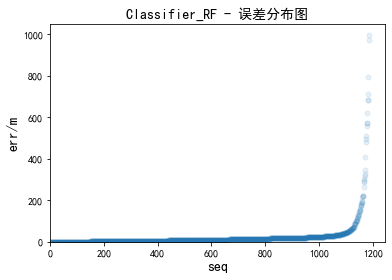

平均绝对误差 MAE :  24.9149
均方误差 MSE :  6746.6732
平均绝对百分比误差 MAPE :  1.0981
绝对误差中位数 MedAE :  9.4000
R2_socre :  0.9693


In [29]:
# 预测的经纬度坐标
pred_loc = np.array([grider.grid_center[idx] for idx in pred_grid])

# 误差
err = [distance(p,t) for p, t in zip(pred_loc, Y_test[['Longitude','Latitude']].values)]

# 绘制误差分布图，其中 x-轴为排序编号，y-轴为对应的误差
err = sorted(err) 
fig = plt.scatter(range(len(err)), err, s=25, alpha=.1)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title(model + ' - 误差分布图', fontsize=14)
plt.xlabel('seq', fontsize=14)
plt.ylabel('err/m', fontsize=14)
plt.xlim(0, )
plt.ylim(0, )
plt.show()
fig.figure.savefig(savepath + model+'/' + model + ' - 误差分布图')

from sklearn.metrics import r2_score
print('平均绝对误差 MAE : ', '%.4f'% np.mean(np.abs(err)))
print('均方误差 MSE : ', '%.4f'% np.mean(np.square(err)))
percentage_err = np.abs(err - np.mean(err)) / np.mean(err)
print('平均绝对百分比误差 MAPE : ', '%.4f'% np.mean(percentage_err))
print('绝对误差中位数 MedAE : ', '%.4f'% np.median(err))
print('R2_socre : ', '%.4f'% r2_score(Y_test[['Longitude','Latitude']], pred_loc, multioutput='uniform_average'))

## 4.3 地图可视化预测效果

In [226]:
# 绘制地图，标注pred_loc和Y_test[['Longitude','Latitude']].values

import folium
# location 经纬度，list 或者 tuple 格式，顺序为 latitude(纬度), longitude(经度)
# zoom_start 缩放值，默认为 10，值越大比例尺越小，地图放大级别越大
tj_map = folium.Map(location=[31.286363, 121.214786],zoom_start=15) # 显示地图
    
# 添加实际标记：Y_test[['Longitude','Latitude']].values
for i in Y_test[['Longitude','Latitude']].values:
    lat = i[1]
    lon = i[0]
    folium.Circle(
        radius=1,
        location=[lat, lon],
        popup='Laurelhurst Park',
        color='#9AFF9A', # 绿色
        fill=False
    ).add_to(tj_map)


# 添加预测标记：pred_loc
for i in pred_loc:
    lat = i[1]
    lon = i[0]
    folium.Circle(
        radius=1,
        location=[lat, lon],
        popup='Laurelhurst Park',
        color='#FF8C69', # 橙色
        fill=False
    ).add_to(tj_map)

tj_map.save(savepath + model+'/' + model + ' - tj_map.html')
tj_map

## 4.4 交叉验证

       MAE      MSE     MAPE   MedAE   R2
1 :  25.3701 8163.4984 1.1256 9.1000 0.9624
2 :  27.4168 9146.4998 1.1666 9.1000 0.9581
3 :  26.2915 8346.6191 1.1554 9.1000 0.9621
4 :  25.4033 7419.0414 1.1177 9.3000 0.9653
5 :  27.4157 9745.6765 1.1648 9.3000 0.9557
6 :  25.3076 7574.7999 1.1194 9.1000 0.9644
7 :  26.5701 9013.1370 1.1425 9.3000 0.9587
8 :  25.2116 7734.8393 1.1167 9.2000 0.9638
9 :  27.8813 9345.4162 1.1735 9.3000 0.9562
10 :  26.2945 8211.4353 1.1378 9.2000 0.9629
all :  26.3163 8470.0963 1.1420 9.2000 0.9609


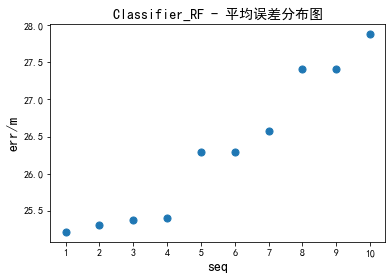

In [30]:
# 重复 10 次训练集/测试集的选择和误差计算

print('       MAE      MSE     MAPE   MedAE   R2')
MAE, MSE, MAPE, MedAE, R2_score = [], [], [], [], []
# 10-fold cross validation
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=200)
    
    # 特征工程
#     # 特征预处理：归一化
#     from sklearn.preprocessing import MinMaxScaler
#     scaler = MinMaxScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#     # 特征预处理：标准化
#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#     # 特征降维：PCA
#     from sklearn.decomposition import PCA
#     pca = PCA(n_components=0.95) # n_components：小数——保留多少比例的信息；整数——减少后的特征维数
#     X_train = pca.fit_transform(X_train) 
#     X_test = pca.transform(X_test)
#     # 特征降维：层级聚类
#     from sklearn import cluster
#     agglo = cluster.FeatureAgglomeration(n_clusters=20) # 最大28
#     X_train = agglo.fit_transform(X_train) 
#     X_test = agglo.transform(X_test)
    
#     # DecisionTree
#     model ='Classifier_DecisionTree'
#     estimator = DecisionTreeClassifier(criterion='entropy', max_depth=None, 
#     min_samples_split=2, min_samples_leaf=1, max_features=None, max_leaf_nodes=None, 
#     min_impurity_decrease=0.0)
#     # GaussianNB
#     model ='Classifier_GaussianNB'
#     estimator = GaussianNB()
#     # KNN
#     model ='Classifier_KNN'
#     estimator = KNeighborsClassifier()
    # RF
    model ='Classifier_RF'
    estimator = RandomForestClassifier()
    
    estimator.fit(X_train, Y_train['grid_id'])

    # 预测的所在栅格编号
    pred_grid= estimator.predict(X_test)
    # 预测的经纬度坐标
    pred_loc = np.array([grider.grid_center[idx] for idx in pred_grid])
    # 误差
    err = [distance(p,t) for p, t in zip(pred_loc, Y_test[['Longitude','Latitude']].values)]
    err = sorted(err) 

    MAE.append(np.mean(np.abs(err)))
    MSE.append(np.mean(np.square(err)))
    percentage_err = np.abs(err - np.mean(err)) / np.mean(err)
    MAPE.append(np.mean(percentage_err))
    MedAE.append(np.median(err))
    R2_score.append(r2_score(Y_test[['Longitude','Latitude']], pred_loc, multioutput='uniform_average'))    
    print('%d : '% (i+1), '%.4f'% np.mean(np.abs(err)), '%.4f'% np.mean(np.square(err)), '%.4f'% np.mean(percentage_err), 
          '%.4f'% np.median(err), '%.4f'% r2_score(Y_test[['Longitude','Latitude']], pred_loc, multioutput='variance_weighted'))
    
print('all : ', '%.4f'% np.mean(MAE), '%.4f'% np.mean(MSE), '%.4f'% np.mean(MAPE), 
      '%.4f'% np.mean(MedAE), '%.4f'% np.mean(R2_score))

# 绘制平均误差概率分布图，其中 x-轴为排序编号，y-轴为对应的平均误差 Average error distribution plot
MAE = sorted(MAE)
fig = plt.scatter(range(1, len(MAE)+1), MAE, s=50)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title(model + ' - 平均误差分布图', fontsize=14)
plt.xticks(np.linspace(1,10,10))
plt.xlabel('seq', fontsize=14)
plt.ylabel('err/m', fontsize=14)
plt.show()
fig.figure.savefig(savepath + model+'/' + model + ' - 平均误差分布图') # 保存